## Verify Data Integrity

In [2]:
import pandas as pd
import os

# Load the CSV files into DataFrames
print("Current working directory:", os.getcwd())
os.chdir('..')
df = pd.read_csv('Data/bills.csv')
venues_df = pd.read_csv('Data/venues.csv')

# Merge the DataFrames on the 'venue_xref_id' column
df = df.merge(venues_df, on='venue_xref_id', how='left')

# Display the first few rows of the DataFrame
df.head()

Current working directory: c:\Users\Natha\OneDrive\Documents\GitHub\TouchBistroEDA\Pipeline


,bill_paid_at_local,bill_total_billed,bill_total_discount_item_level,bill_total_gratuity,bill_total_net,bill_total_tax,bill_total_voided,bill_uuid,business_date,order_duration_seconds,...,payment_amount,payment_count,payment_total_tip,sales_revenue_with_tax,venue_xref_id,waiter_uuid,concept,city,country,start_of_day_offset
0,2024-07-01 09:17:01,21.81,0.0,0.0,19.30,2.51,0.0,240701091701~4D63608F-523C-4EFF-9A4F-78D6C44B5159,2024-07-01,46,...,21.81,1,0.0,21.81,39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...,161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD,NaN,Collingwood,CA,00:00:00
1,2024-07-01 13:37:00,48.95,0.0,0.0,43.32,5.63,0.0,240701133659~3A0BEDE2-E9E5-484D-B909-780E485F0D69,2024-07-01,288,...,48.95,1,0.0,48.95,39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...,161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD,NaN,Collingwood,CA,00:00:00
2,2024-07-01 11:19:32,26.94,0.0,0.0,23.84,3.10,0.0,240701111931~670EEB85-E939-4924-B92F-C95076B7E930,2024-07-01,135,...,26.94,1,0.0,26.94,39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...,161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD,NaN,Collingwood,CA,00:00:00
3,2024-07-01 15:05:59,3.96,0.0,0.0,3.77,0.19,0.0,240701150558~3D6F473E-D5EF-4BB8-AFAB-30DB2A0764C0,2024-07-01,48,...,3.96,1,0.0,3.96,39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...,161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD,NaN,Collingwood,CA,00:00:00
4,2024-07-01 12:41:00,3.36,0.0,0.0,3.20,0.16,0.0,240701124059~0521794C-51FC-4C30-A368-995CE4DE105F,2024-07-01,103,...,3.36,1,0.0,3.36,39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...,161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD,NaN,Collingwood,CA,00:00:00


## Check for Outliers for Innacurate Order Duration

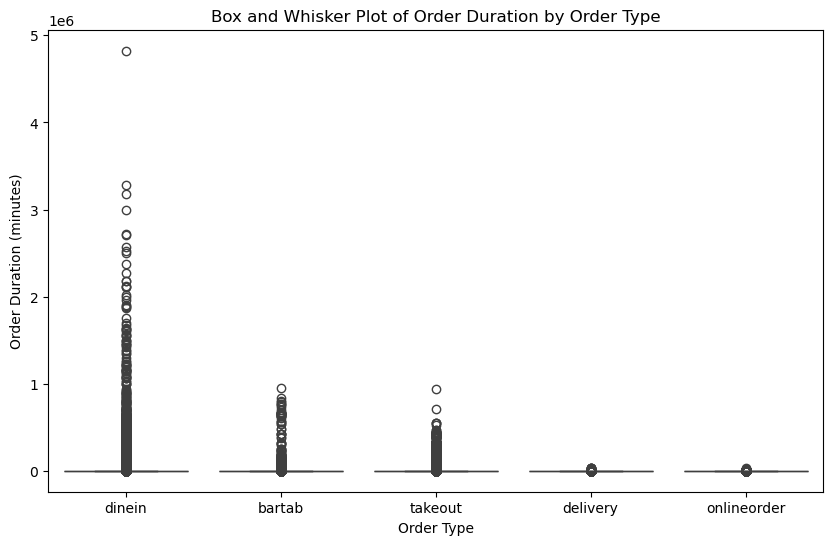

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert order duration from seconds to minutes
df['order_duration_minutes'] = df['order_duration_seconds'] / 60

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


## Check where the Outliers Begin

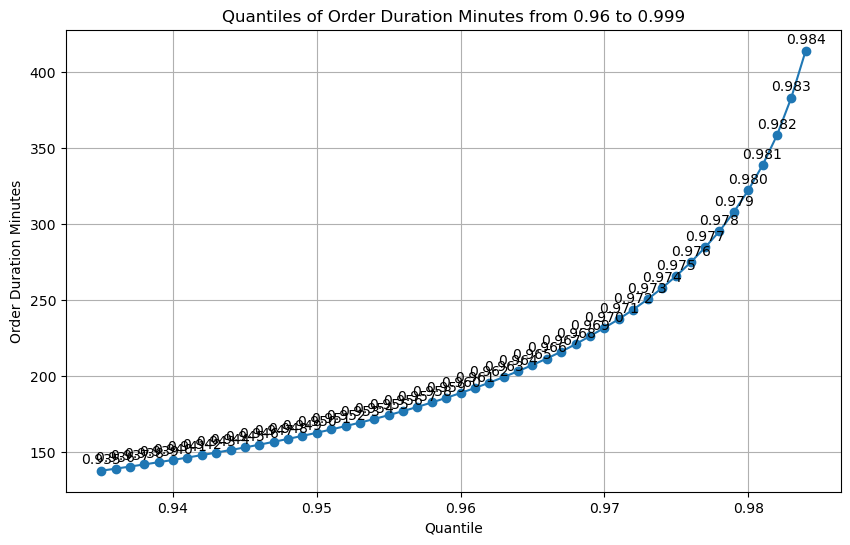

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate quantiles from 0.96 to 0.999 in 0.001 increments
quantiles = np.arange(0.935, 0.985, 0.001)
quantile_values = [df['order_duration_minutes'].quantile(q) for q in quantiles]

# Plot the quantiles
plt.figure(figsize=(10, 6))
plt.plot(quantiles, quantile_values, marker='o')

# Annotate each point with the quantile number
for i, q in enumerate(quantiles):
    plt.annotate(f'{q:.3f}', (q, quantile_values[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Quantiles of Order Duration Minutes from 0.96 to 0.999')
plt.xlabel('Quantile')
plt.ylabel('Order Duration Minutes')
plt.grid(True)
plt.show()

### Data is Valid Until 0.994

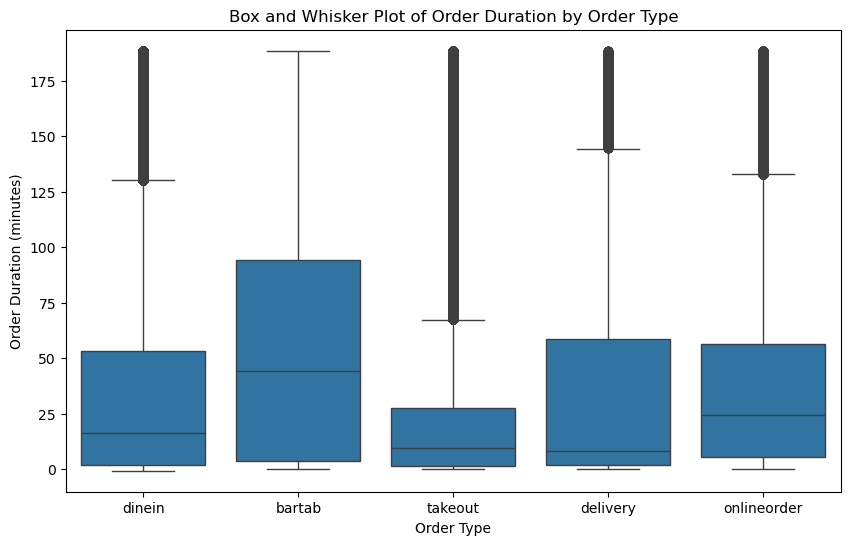

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows where order_duration_minutes is greater than 180
filtered_df = df[df['order_duration_minutes'] <= df['order_duration_minutes'].quantile(0.96)]

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=filtered_df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


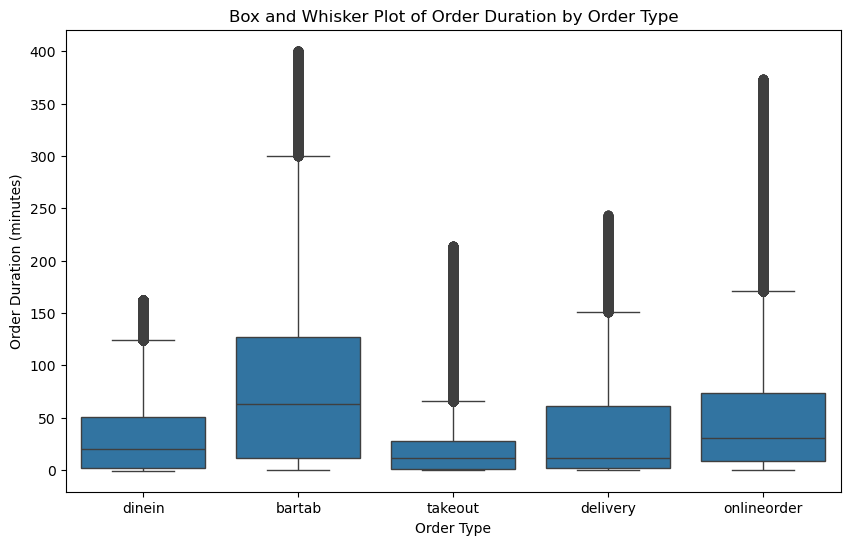

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 0.96 quantile for each order type
quantile_96_per_type = df.groupby('order_take_out_type_label')['order_duration_minutes'].quantile(0.96)

# Calculate the median for each order type
median_per_type = df.groupby('order_take_out_type_label')['order_duration_minutes'].median()

# Replace excluded data points with the respective median for each order type
df['order_duration_minutes'] = df.apply(
    lambda row: median_per_type[row['order_take_out_type_label']] if row['order_duration_minutes'] > quantile_96_per_type[row['order_take_out_type_label']] else row['order_duration_minutes'],
    axis=1
)

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


### Time-Series Frequency Analysis

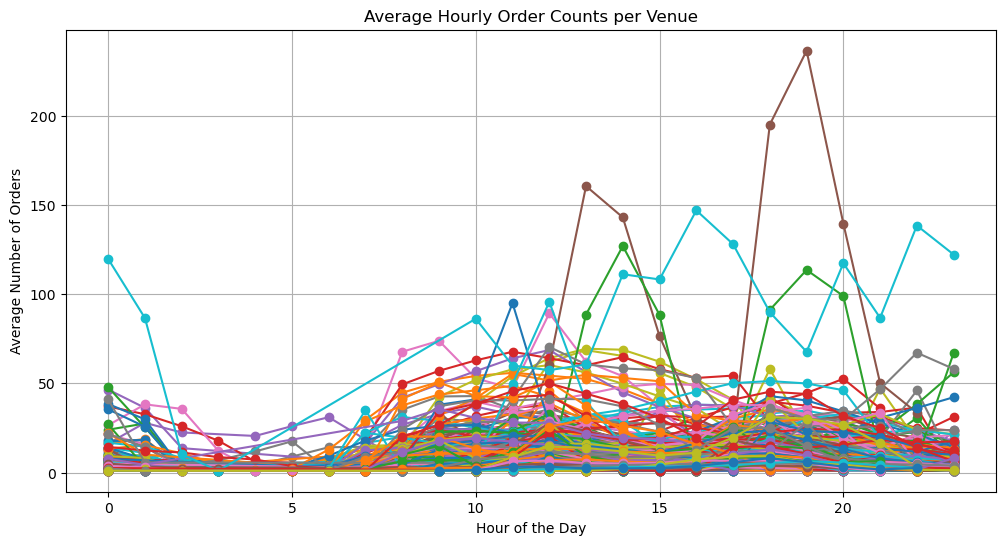

In [7]:
# Create a time series DataFrame from the existing filtered_df
time_series_df = filtered_df[['order_seated_at_local', 'order_uuid', 'venue_xref_id', 'business_date']].copy()
time_series_df.set_index('order_seated_at_local', inplace=True)
time_series_df.index = pd.to_datetime(time_series_df.index)  # Ensure the index is a DatetimeIndex
time_series_df['order_count'] = 1

# Extract the hour from the datetime index
time_series_df['hour'] = time_series_df.index.hour

# Group by venue, business date, and hour, then sum the order counts
hourly_order_counts = time_series_df.groupby(['venue_xref_id', 'business_date', 'hour'])['order_count'].sum().reset_index()

# Calculate the average order count per hour for each venue
average_hourly_order_counts = hourly_order_counts.groupby(['venue_xref_id', 'hour'])['order_count'].mean().reset_index()

# Plot the average hourly order counts for each venue
plt.figure(figsize=(12, 6))
for venue in average_hourly_order_counts['venue_xref_id'].unique():
    venue_data = average_hourly_order_counts[average_hourly_order_counts['venue_xref_id'] == venue]
    plt.plot(venue_data['hour'], venue_data['order_count'], marker='o', label=venue)

plt.title('Average Hourly Order Counts per Venue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Orders')
# plt.legend(title='Venue')
plt.grid(True)
plt.show()


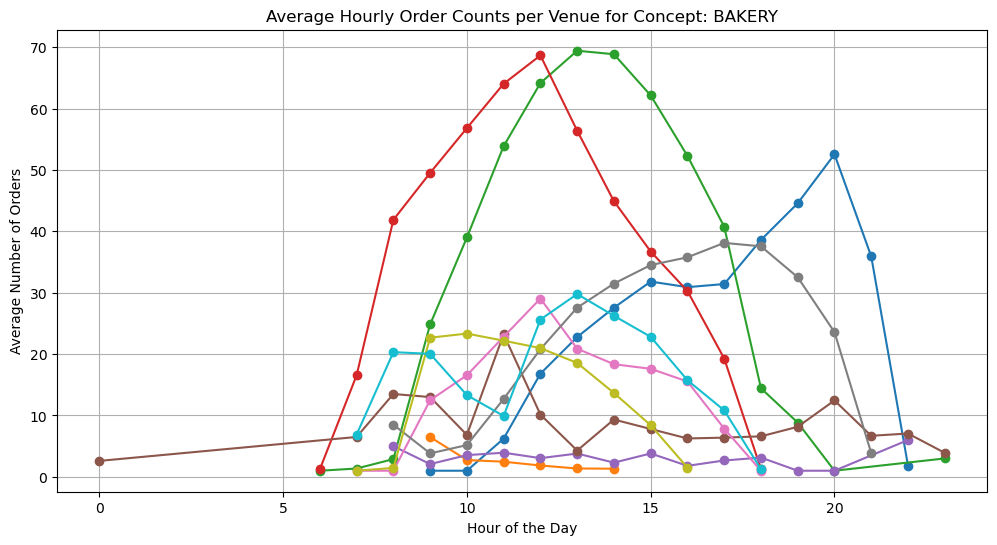

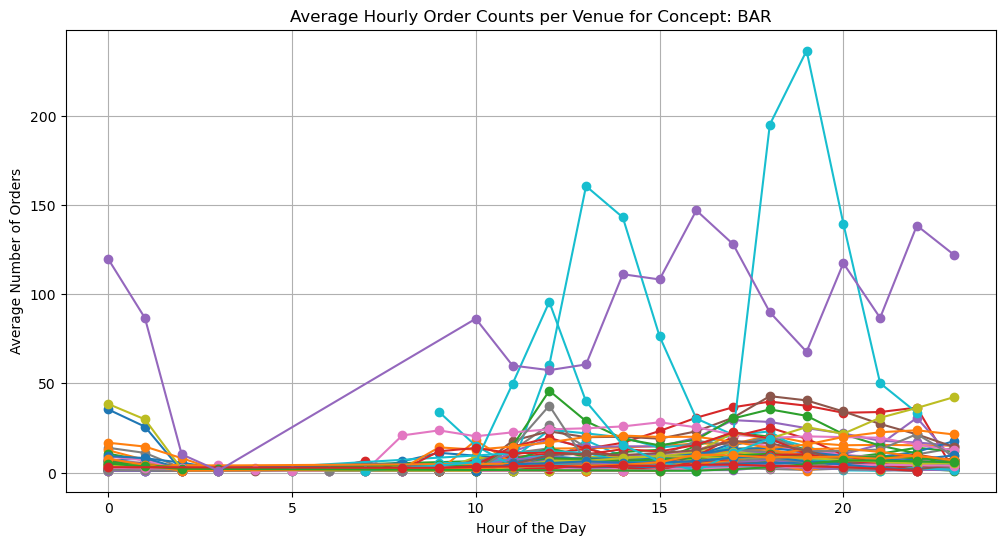

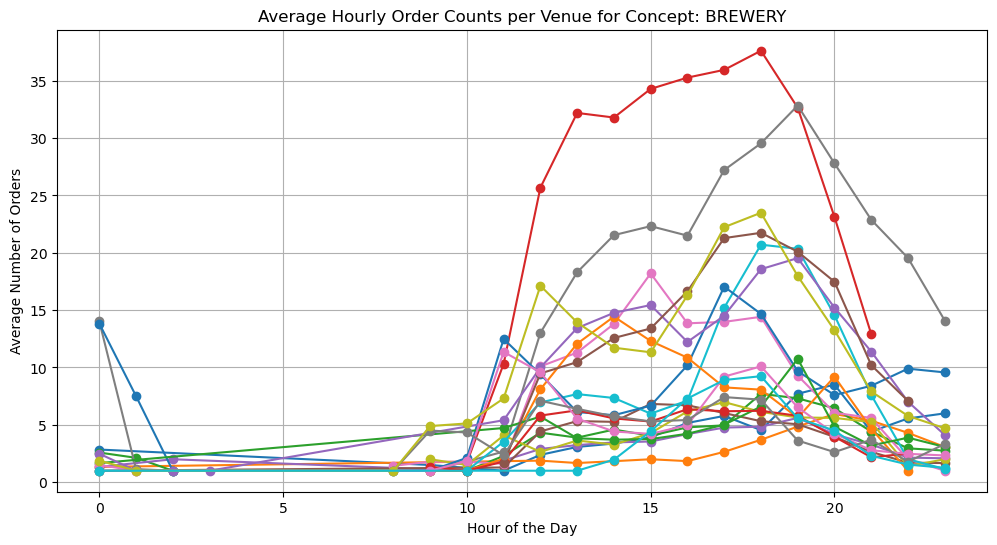

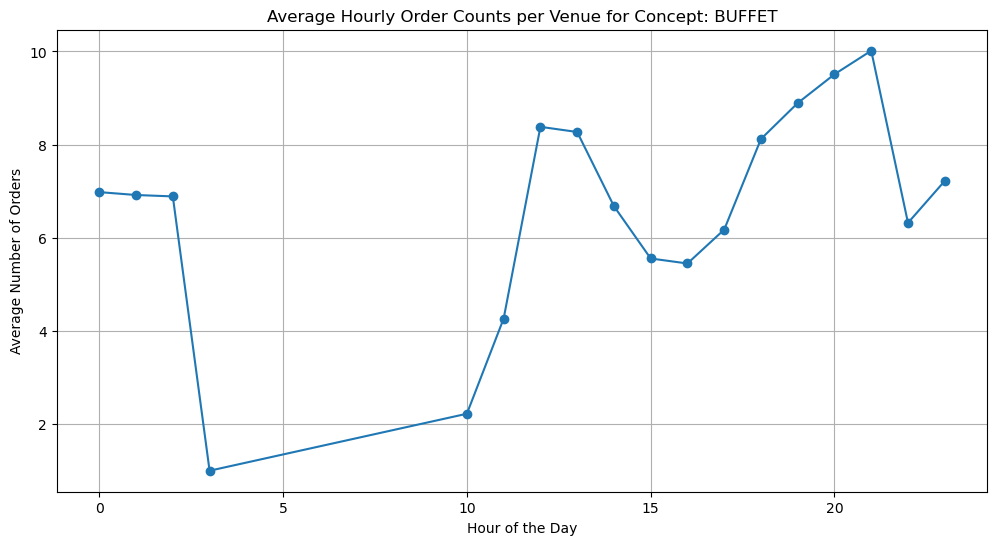

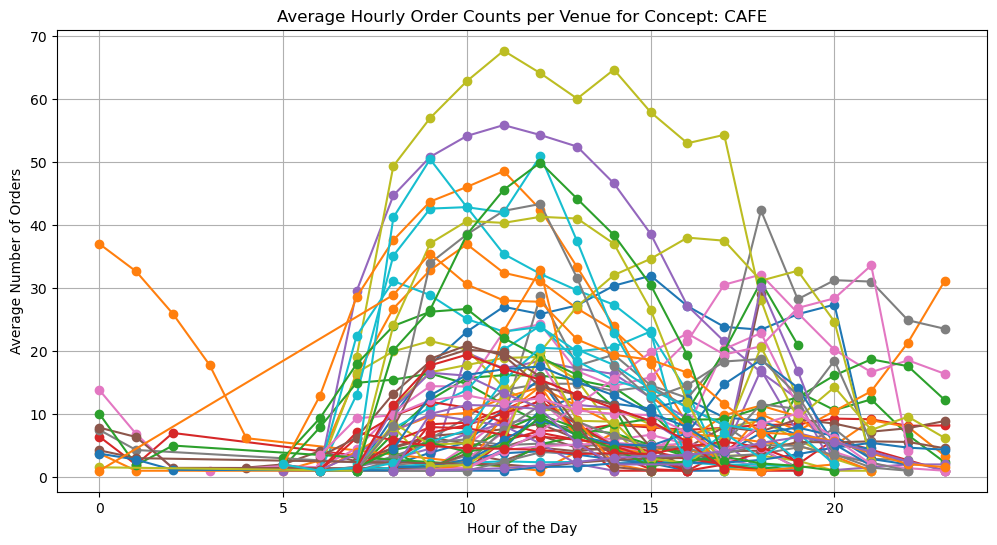

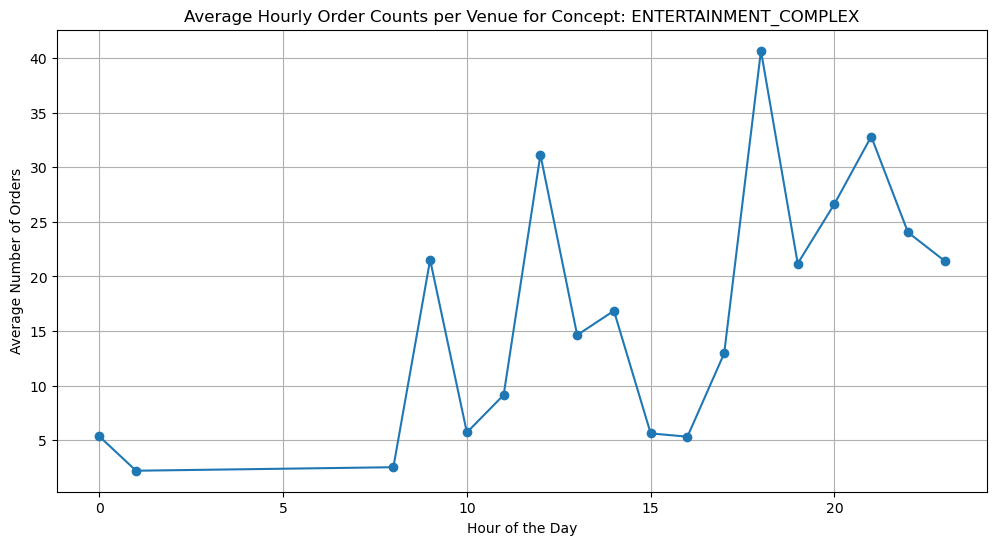

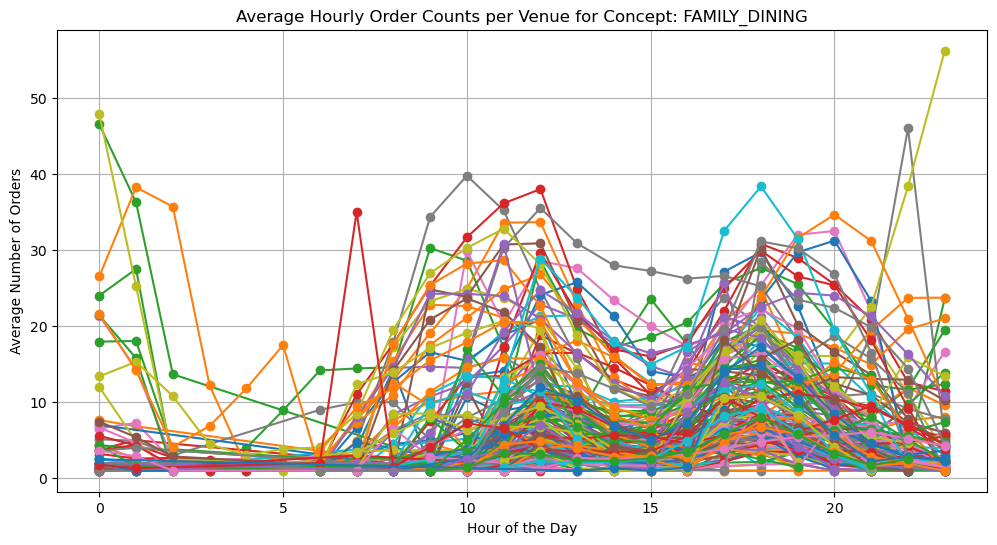

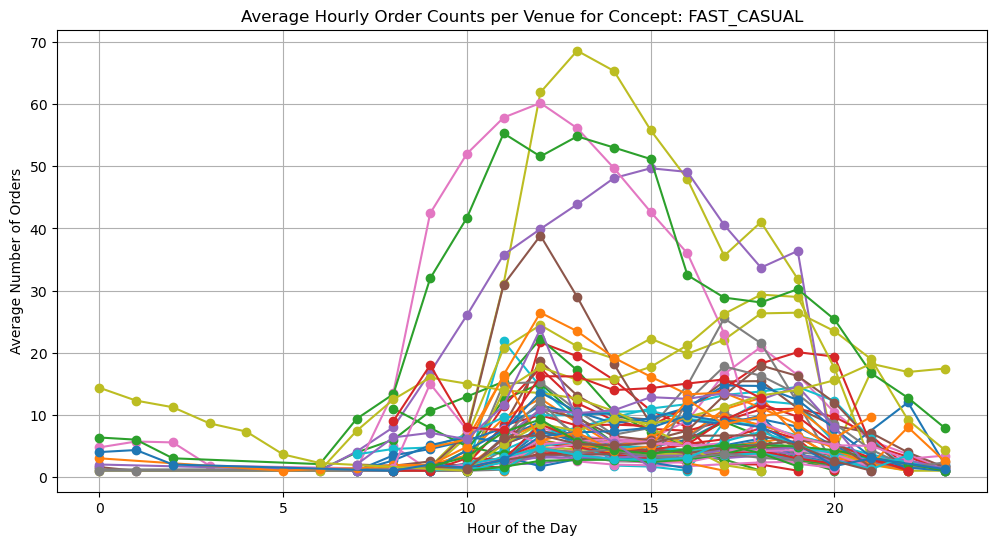

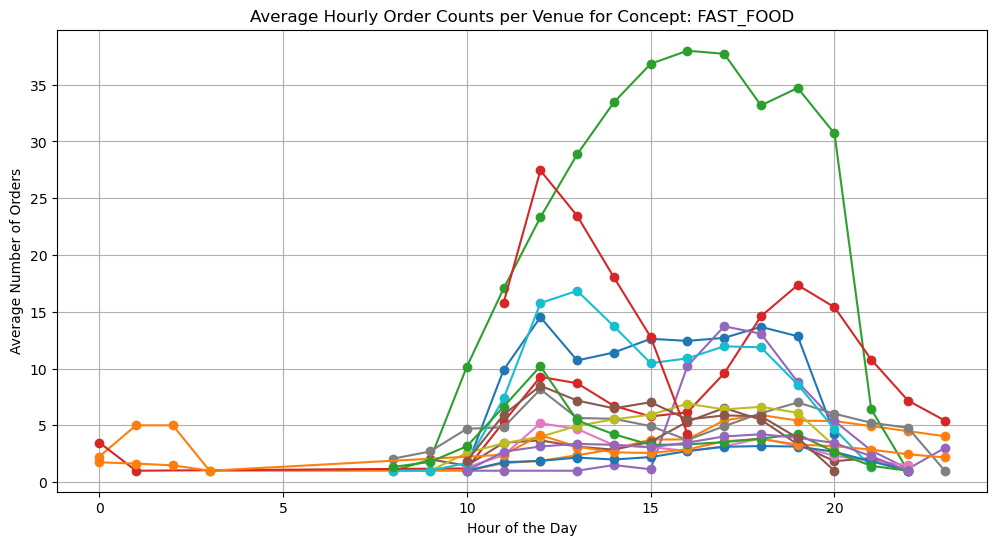

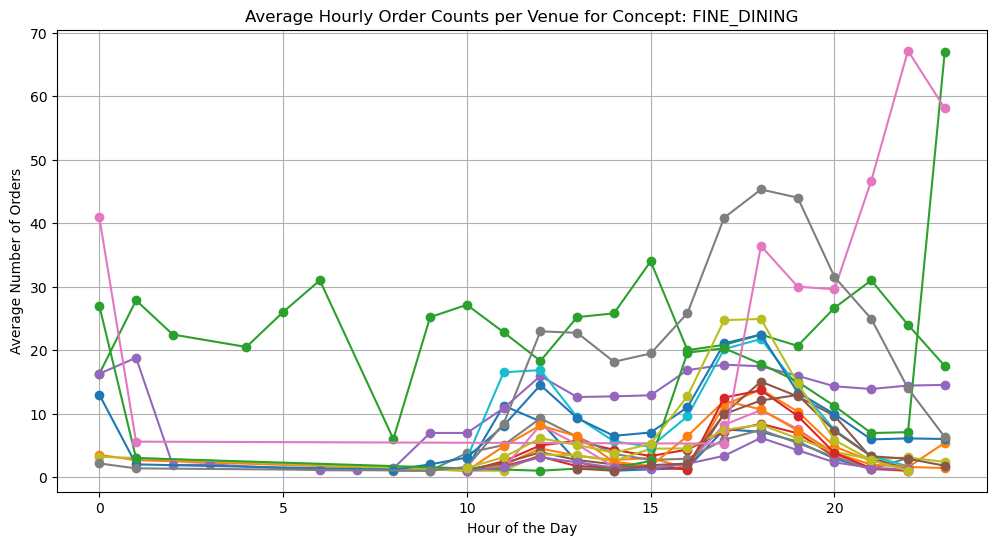

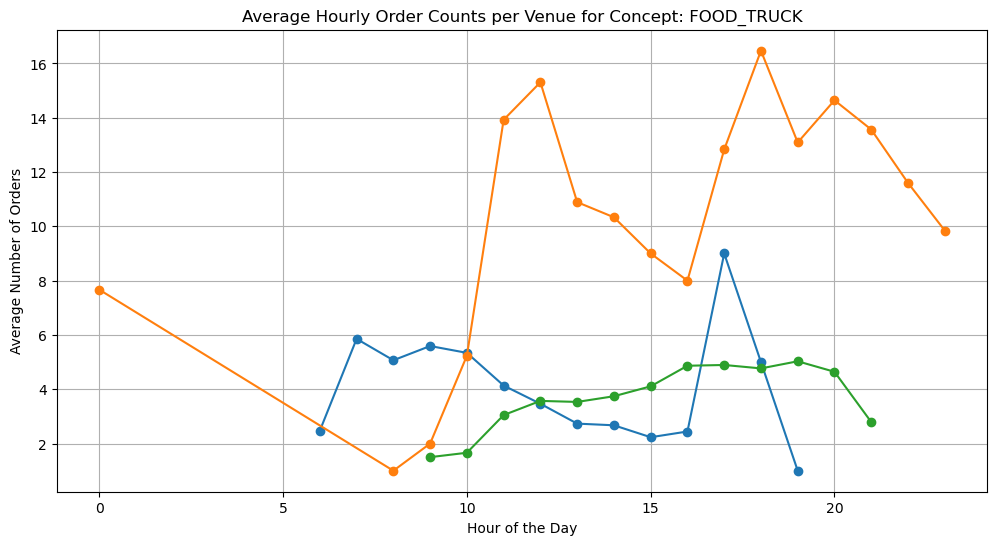

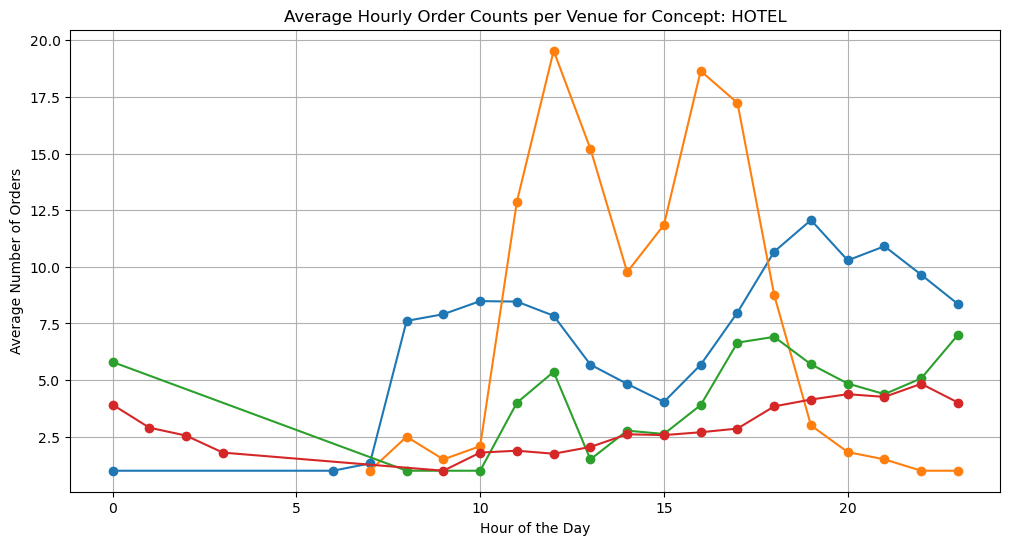

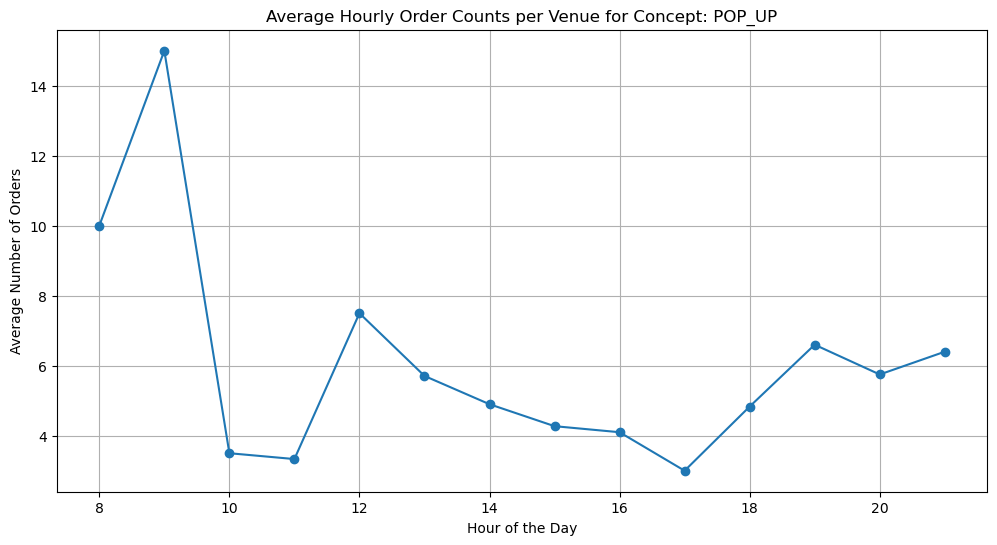

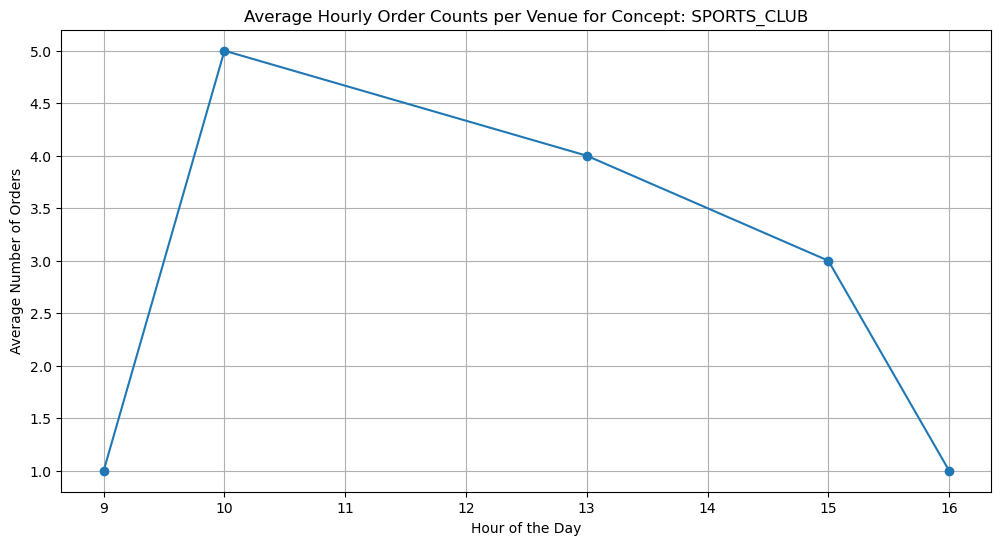

In [9]:
# Create a time series DataFrame from the existing filtered_df
time_series_df = filtered_df[['order_seated_at_local', 'order_uuid', 'venue_xref_id', 'business_date', 'concept']].copy()
time_series_df.set_index('order_seated_at_local', inplace=True)
time_series_df.index = pd.to_datetime(time_series_df.index)  # Ensure the index is a DatetimeIndex
time_series_df['order_count'] = 1

# Extract the hour from the datetime index
time_series_df['hour'] = time_series_df.index.hour

# Group by concept, venue, business date, and hour, then sum the order counts
hourly_order_counts = time_series_df.groupby(['concept', 'venue_xref_id', 'business_date', 'hour'])['order_count'].sum().reset_index()

# Calculate the average order count per hour for each concept and venue
average_hourly_order_counts = hourly_order_counts.groupby(['concept', 'venue_xref_id', 'hour'])['order_count'].mean().reset_index()

# Plot the average hourly order counts for each concept and venue
concepts = average_hourly_order_counts['concept'].unique()
for concept in concepts:
    plt.figure(figsize=(12, 6))
    concept_data = average_hourly_order_counts[average_hourly_order_counts['concept'] == concept]
    for venue in concept_data['venue_xref_id'].unique():
        venue_data = concept_data[concept_data['venue_xref_id'] == venue]
        plt.plot(venue_data['hour'], venue_data['order_count'], marker='o', label=venue)
    
    plt.title(f'Average Hourly Order Counts per Venue for Concept: {concept}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Orders')
    # plt.legend(title='Venue')
    plt.grid(True)
    plt.show()
